# Praca domowa nr 4

Piotr Marciniak


## Wczytanie danych

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Ładowanie zbiorów
### Zbiór apartments

In [2]:
apartments = pd.read_feather("apartments.feather")
apartments

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897.0,1953.0,25.0,3,1.0,Srodmiescie
1,1818.0,1992.0,143.0,9,5.0,Bielany
2,3643.0,1937.0,56.0,1,2.0,Praga
3,3517.0,1995.0,93.0,7,3.0,Ochota
4,3013.0,1992.0,144.0,6,5.0,Mokotow
...,...,...,...,...,...,...
995,6355.0,1921.0,44.0,2,2.0,Srodmiescie
996,3422.0,1921.0,48.0,10,2.0,Bemowo
997,3098.0,1980.0,85.0,3,3.0,Bemowo
998,4192.0,1942.0,36.0,7,1.0,Zoliborz


In [3]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   m2.price           1000 non-null   float64 
 1   construction.year  1000 non-null   float64 
 2   surface            1000 non-null   float64 
 3   floor              1000 non-null   int32   
 4   no.rooms           1000 non-null   float64 
 5   district           1000 non-null   category
dtypes: category(1), float64(4), int32(1)
memory usage: 36.6 KB


In [4]:
apartments.describe()

,m2.price,construction.year,surface,floor,no.rooms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3487.019000,1964.823000,85.590000,5.623000,3.360000
std,906.691651,25.831511,37.874799,2.899876,1.381415
min,1607.000000,1920.000000,20.000000,1.000000,1.000000
25%,2857.000000,1943.000000,53.000000,3.000000,2.000000
50%,3386.000000,1965.000000,85.500000,6.000000,3.000000
75%,4018.250000,1988.000000,118.000000,8.000000,4.000000
max,6595.000000,2010.000000,150.000000,10.000000,6.000000


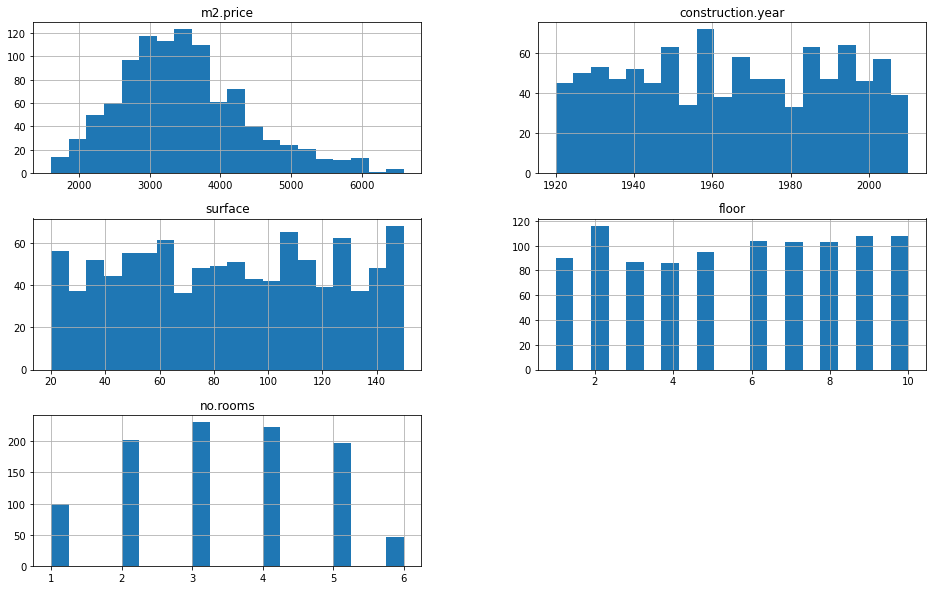

In [5]:
apartments.hist(figsize=(16, 10), bins=20)
plt.show()

Zmienne *surface*, *construction.year*, *floor* mają prawie rozkłady jednostajne. Natomiast zmienna *m2.price* ma górkę w okolicy 3000-4000.

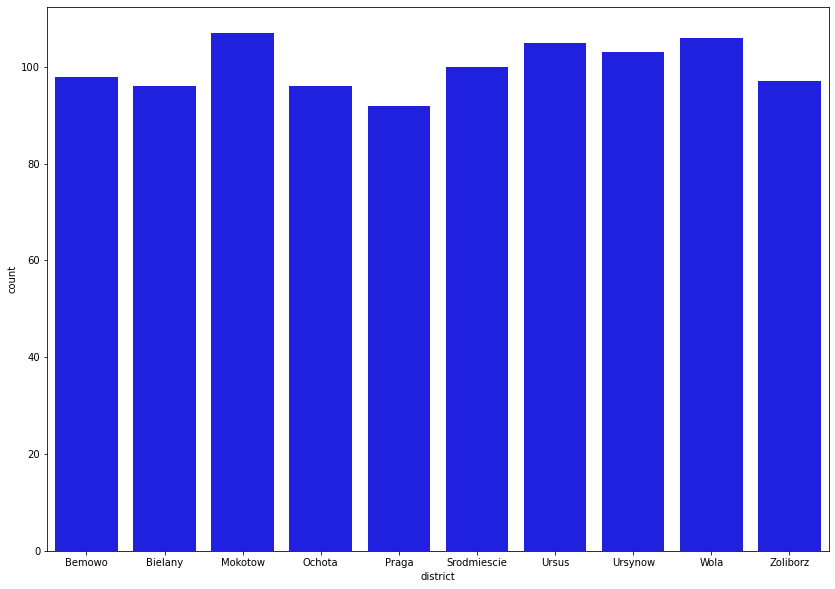

In [6]:
plt.figure(figsize=(14,10))
sns.countplot(data=apartments,x="district", color="Blue")
plt.show()

Prawie jednostajny rozkład

In [7]:
X_apartments = apartments.drop('m2.price', axis=1)
X_apartments['floor'] = X_apartments['floor'].astype('float64')
y_apartments = apartments["m2.price"]

### Zbiór dodatkowy - Breast_cancer
Zbiór na temat złośliwości raka piersi

In [8]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer(as_frame=True)
X_cancer = cancer.get('data')
y_cancer = cancer.get('target')

In [9]:
print(cancer.get('DESCR'))

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [10]:
y_cancer.value_counts()/y_cancer.shape[0]

1    0.627417
0    0.372583
Name: target, dtype: float64

Dane są przechylone w kierunku przypadków łagodnych, co może wpływać na predykcję przypadków złośliwych (będziemy je gorzej znajdować).

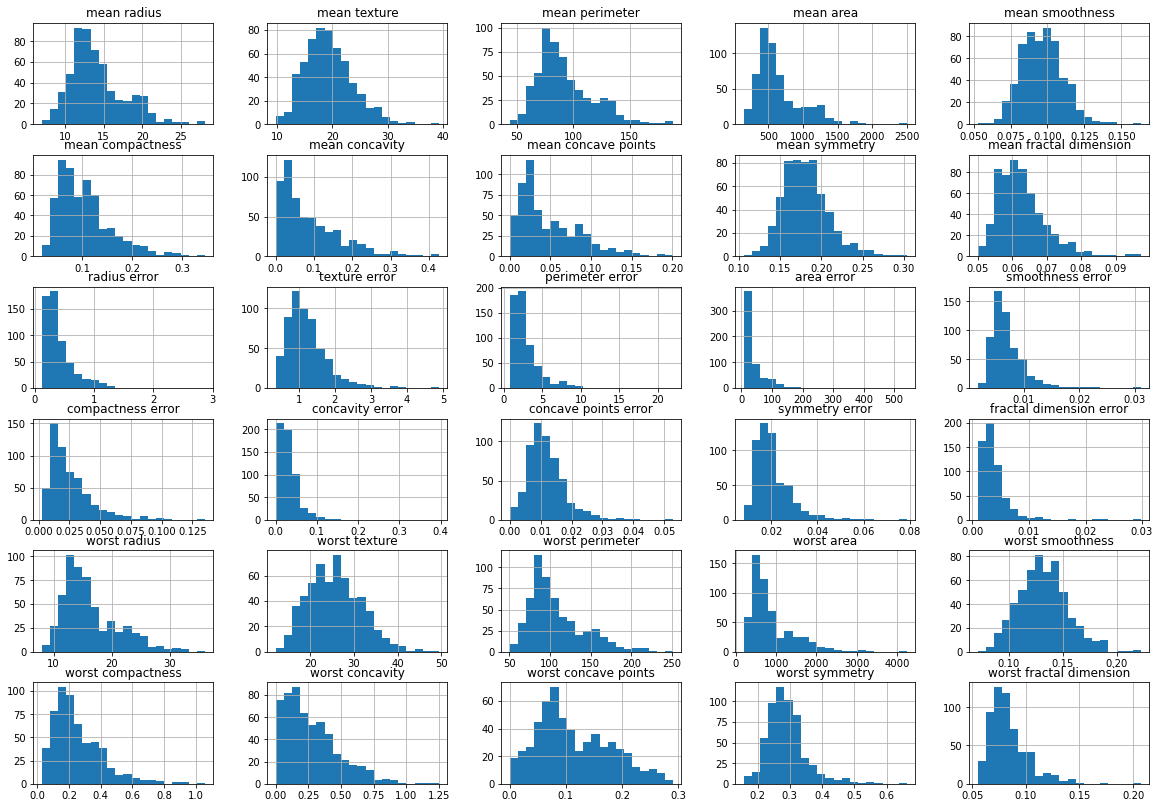

In [11]:
X_cancer.hist(figsize=(20,14), bins=20)
plt.show()

Zmienna *area error* jest przechylona w stronę 0.

## Basic SVM
### Zbiór apartments

In [12]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = ColumnTransformer([
    ("One Hot Encoder", OneHotEncoder(sparse=False), ["district"])
])

svr = Pipeline([
    ("Encoder", one_hot_enc),
    ("SVR", SVR())
])

regression_metrics = {
    "r2": make_scorer(r2_score),
    "RMSE": make_scorer(mean_squared_error, squared=False)
}


def r2_rmse(result):
    print(f"Mean R2: {np.mean(result.get('test_r2'))} +- {np.std(result.get('test_r2'))}")
    print(f"Mean RMSE: {np.mean(result.get('test_RMSE'))} +- {np.std(result.get('test_RMSE'))}")

    
res = cross_validate(svr, X_apartments, y_apartments, scoring=regression_metrics, cv=5)
r2_rmse(res)

Mean R2: 0.044334408219999635 +- 0.02095123321932841
Mean RMSE: 882.5443683027349 +- 62.18850241429629


### Zbiór Breast Cancer

In [13]:
clasification_metrics = ['accuracy','roc_auc']

def acc_and_roc(result):
    print(f"Mean accuracy: {np.mean(result.get('test_accuracy'))} +- {np.std(result.get('test_accuracy'))}")
    print(f"Mean roc auc: {np.mean(result.get('test_roc_auc'))} +- {np.std(result.get('test_roc_auc'))}")
    
res = cross_validate(SVC(probability=True), X_cancer, y_cancer, scoring=clasification_metrics, cv=5)

acc_and_roc(res)

Mean accuracy: 0.9121720229777983 +- 0.03544367440584207
Mean roc auc: 0.973961923998773 +- 0.01058785975956499


## Standaryzacja SVM
### Zbiór apartments

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

standarize_svr = Pipeline([
    ("Encoder", one_hot_enc),
    ("StandardScaler", StandardScaler()),
    ("SVR", SVR())
])


res = cross_validate(standarize_svr, X_apartments, y_apartments, scoring=regression_metrics, cv=5)
r2_rmse(res)

Mean R2: 0.04441035020942099 +- 0.02084714117050145
Mean RMSE: 882.5038828541947 +- 62.09643542908353


### Zbiór Breast Cancer

In [15]:
standarize_svc = Pipeline([
    ("StandardScaler", StandardScaler()),
    ("SVC", SVC(probability=True))
])

res = cross_validate(standarize_svc, X_cancer, y_cancer, scoring=clasification_metrics, cv=5)

acc_and_roc(res)

Mean accuracy: 0.9736376339077782 +- 0.014678541667933545
Mean roc auc: 0.995915826570101 +- 0.003738441338875178


Jak widzimy standaryzacja pomogła nam uzyskać lepsze wyniki, przy czym nie są to znaczne różnice w przypadku zbioru *apartments*, ale dla *Breast Cancer* widzimy juz znaczną poprawę. Zatem widzimy, że dając dane **SVM** powinniśmy sprawdzić, jak sprawuje się on po standaryzacji. 

## Random Grid Search z SVM

Sprawdźmy parametry ustandaryzowanego svm i spróbujmy dobrać je jescze lepiej.

In [16]:
standarize_svr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'Encoder', 'StandardScaler', 'SVR', 'Encoder__n_jobs', 'Encoder__remainder', 'Encoder__sparse_threshold', 'Encoder__transformer_weights', 'Encoder__transformers', 'Encoder__verbose', 'Encoder__One Hot Encoder', 'Encoder__One Hot Encoder__categories', 'Encoder__One Hot Encoder__drop', 'Encoder__One Hot Encoder__dtype', 'Encoder__One Hot Encoder__handle_unknown', 'Encoder__One Hot Encoder__sparse', 'StandardScaler__copy', 'StandardScaler__with_mean', 'StandardScaler__with_std', 'SVR__C', 'SVR__cache_size', 'SVR__coef0', 'SVR__degree', 'SVR__epsilon', 'SVR__gamma', 'SVR__kernel', 'SVR__max_iter', 'SVR__shrinking', 'SVR__tol', 'SVR__verbose'])

Dla ustandaryzowanego ustawienie hipeparametru *gamma* jako scale $\left(\frac{1}{n \text{Var} X}\right)$ a nie *auto* $\left(\frac{1}{n}\right)$, nie ma znaczenia bo wariancja po ustandaryzowaniu i tak się równa 1, zatem spróbujmy kilka wartości wprowadzonych z palca.

### Zbiór apartments

In [17]:
from sklearn.model_selection import RandomizedSearchCV

params_svr = [
    {
        'SVR__kernel': ['rbf'],
        'SVR__C': [0.1, 0.5, 1, 3, 5, 8],
        'SVR__gamma': ['scale', 0.5, 2, 0.1, 0.001]
    },
    {
        'SVR__kernel': ['poly'],
        'SVR__degree': [2, 3, 4],
        'SVR__C': [0.1, 0.5, 1, 3, 5, 8],
        'SVR__gamma': ['scale', 0.5, 2, 0.1, 0.001]
    }
]

rand_svr = RandomizedSearchCV(standarize_svr, param_distributions=params_svr, n_jobs=-1, 
                              scoring=regression_metrics, n_iter=40, refit='RMSE', cv=5)
rand_svr.fit(X=X_apartments, y=y_apartments)

columns_svr = ["param_SVR__kernel","param_SVR__gamma", "param_SVR__C", "param_SVR__degree",
           "mean_test_RMSE", 'mean_test_r2']
score = pd.DataFrame(rand_svr.cv_results_)[columns_svr]
score.sort_values('mean_test_RMSE', ascending=True)

,param_SVR__kernel,param_SVR__gamma,param_SVR__C,param_SVR__degree,mean_test_RMSE,mean_test_r2
2,poly,0.5,3,4,602.430091,0.550833
7,poly,2,0.1,4,602.430408,0.550833
28,poly,0.5,5,4,602.430408,0.550833
37,poly,0.5,8,4,602.430408,0.550833
30,poly,2,0.5,4,602.430408,0.550833
36,poly,2,8,4,602.430408,0.550833
3,poly,0.5,1,4,602.441523,0.550824
35,poly,2,0.1,3,602.538945,0.550678
23,poly,0.5,0.5,4,602.875021,0.550317
24,poly,0.5,0.5,3,607.748352,0.543626


Najlepsze wyniki uzyskał ustandaryzowany SVM z jądrem wielomianowym o parametrach:
* degree = 4,
* C = 3,
* gamma = 0.5.

### Zbiór Breast Cancer

In [18]:
standarize_svc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'StandardScaler', 'SVC', 'StandardScaler__copy', 'StandardScaler__with_mean', 'StandardScaler__with_std', 'SVC__C', 'SVC__break_ties', 'SVC__cache_size', 'SVC__class_weight', 'SVC__coef0', 'SVC__decision_function_shape', 'SVC__degree', 'SVC__gamma', 'SVC__kernel', 'SVC__max_iter', 'SVC__probability', 'SVC__random_state', 'SVC__shrinking', 'SVC__tol', 'SVC__verbose'])

In [19]:
params_svc = [
    {
        'SVC__kernel': ['rbf'],
        'SVC__C': [0.1, 0.5, 1, 3, 5, 8],
        'SVC__gamma': ['scale', 0.5, 2, 0.1, 0.001]
    },
    {
        'SVC__kernel': ['poly'],
        'SVC__degree': [2, 3, 4],
        'SVC__C': [0.1, 0.5, 1, 3, 5, 8],
        'SVC__gamma': ['scale', 0.5, 2, 0.1, 0.001]
    }
]

rand_svc = RandomizedSearchCV(standarize_svc, param_distributions=params_svc, n_jobs=-1, 
                              scoring=clasification_metrics, n_iter=40, refit='roc_auc', cv=5)

rand_svc.fit(X=X_cancer, y=y_cancer)

columns_svc = ["param_SVC__kernel","param_SVC__gamma", "param_SVC__C", "param_SVC__degree",
           "mean_test_accuracy", 'mean_test_roc_auc']

score = pd.DataFrame(rand_svc.cv_results_)[columns_svc]
score.sort_values('mean_test_roc_auc', ascending=False)

,param_SVC__kernel,param_SVC__gamma,param_SVC__C,param_SVC__degree,mean_test_accuracy,mean_test_roc_auc
28,rbf,scale,3,NaN,0.978932,0.996706
16,rbf,0.001,5,NaN,0.968390,0.994394
20,rbf,0.001,8,NaN,0.966636,0.994328
37,poly,scale,8,3,0.959618,0.993872
19,poly,scale,1,3,0.903400,0.993224
13,rbf,0.001,1,NaN,0.947306,0.991829
21,poly,scale,5,3,0.950846,0.991708
5,rbf,0.1,0.5,NaN,0.949030,0.990452
35,rbf,0.1,3,NaN,0.961326,0.990052
33,rbf,0.001,0.1,NaN,0.797997,0.986239


Najlepsze wyniki uzyskał ustandaryzowany **SVM** z jądrem gaussowskim, 
* gamma = scale,
* C = 3.

# Zadanie bonusowe

In [20]:
allegro_df = pd.read_csv("https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1")
allegro_df

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420015,420015,2016-04-03 20:27:13,6099625607,"['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwar...",0,0,iwona7012,180.00,0,0,0,176,Kraśnik,RTV i AGD
420016,420016,2016-04-03 22:35:02,6099634607,"['Uroda', 'Makijaż', 'Oczy', 'Tusze do rzęs']",1,1,Dolce_Cosmetics,14.99,1,2,0,34851,Dzierżoniów,Uroda
420017,420017,2016-04-03 22:38:57,6099780407,"['Odzież, Obuwie, Dodatki', 'Przebrania, kosti...",1,1,pewex4all,5.99,1,470,0,983,Supraśl,"Odzież, Obuwie, Dodatki"
420018,420018,2016-04-03 22:44:17,6099801007,"['Dla Dzieci', 'Rowery i pojazdy', 'Rowery bie...",1,0,kostasia,200.00,0,0,0,163,Poznań,Dla Dzieci


Widzimy, że *it_location* jest różnie napisane, czasami z wielkich liter np. BIAŁYSTOK, dlatego przed kodowaniem, wszystkie zmienne tekstowe zamienimy na mniejsze litery.

In [21]:
allegro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

In [22]:
allegro_df.describe()

,lp,item_id,pay_option_on_delivery,pay_option_transfer,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating
count,420020.000000,4.200200e+05,420020.000000,420020.000000,420020.000000,420020.000000,420020.000000,420020.000000,420020.000000
mean,210009.500000,5.809067e+09,0.877972,0.812495,76.811350,0.583456,6748.274823,0.016694,20402.593496
std,121249.474369,3.387402e+08,0.327318,0.390317,390.326271,0.492987,23387.248064,0.128124,36682.898636
min,0.000000,4.179879e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,105004.750000,5.652990e+09,1.000000,1.000000,9.000000,0.000000,6.000000,0.000000,1581.000000
50%,210009.500000,5.968052e+09,1.000000,1.000000,24.990000,1.000000,95.000000,0.000000,6711.000000
75%,315014.250000,6.070760e+09,1.000000,1.000000,68.450000,1.000000,931.000000,0.000000,21007.000000
max,420019.000000,6.099927e+09,1.000000,1.000000,119000.000000,1.000000,99999.000000,1.000000,292074.000000


In [23]:
X_allegro = allegro_df[['main_category', 'categories', 'it_location']]
y_allegro = allegro_df.price

Sprawdźmy, dokładniej spostrzeżenia powyżej dotyczącego Białystoku.

In [24]:
bialystok = X_allegro.loc[X_allegro.it_location.apply(lambda x: x.lower() == "białystok" ), ["it_location"]]
bialystok.it_location.value_counts()

Białystok    7356
BIAŁYSTOK    1667
białystok     173
Name: it_location, dtype: int64

Jak widzimy nazwy są podawane różną wielkością liter, dlatego przed użyciem encodera, znormalizujemy je do małych liter.

In [25]:
X_allegro['it_location'] = X_allegro.it_location.str.lower()

In [26]:
X_allegro

,main_category,categories,it_location
0,Komputery,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",warszawa
1,"Odzież, Obuwie, Dodatki","['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",warszawa
2,Dom i Ogród,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",leszno
3,Książki i Komiksy,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",wola krzysztoporska
4,"Odzież, Obuwie, Dodatki","['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",białystok
...,...,...,...
420015,RTV i AGD,"['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwar...",kraśnik
420016,Uroda,"['Uroda', 'Makijaż', 'Oczy', 'Tusze do rzęs']",dzierżoniów
420017,"Odzież, Obuwie, Dodatki","['Odzież, Obuwie, Dodatki', 'Przebrania, kosti...",supraśl
420018,Dla Dzieci,"['Dla Dzieci', 'Rowery i pojazdy', 'Rowery bie...",poznań


Sprawdźmy pozostałe kolumny.

In [27]:
X_allegro.categories.value_counts()

['Dom i Ogród', 'Ogród', 'Rośliny', 'Rośliny owocowe']                                        3753
['Dom i Ogród', 'Ogród', 'Rośliny', 'Drzewa i krzewy liściaste']                              2914
['Dom i Ogród', 'Ogród', 'Rośliny', 'Bulwy, cebulki, kłącza']                                 2693
['Odzież, Obuwie, Dodatki', 'Odzież damska', 'Sukienki']                                      2485
['Motoryzacja', 'Opony', 'Opony samochodowe', 'Letnie']                                       2473
                                                                                              ... 
['Antyki i Sztuka', 'Antykwariat', 'Książki do 1950', 'Literatura', 'Historia Literatury']       1
['Dla Dzieci', 'Okazje, przyjęcia', 'Zaproszenia', 'Pozostałe']                                  1
['Motoryzacja', 'Samochody', 'Osobowe', 'Audi', 'A6', 'C5 (1997-2004)']                          1
['Motoryzacja', 'Części do maszyn', 'Części do wózków widłowych', 'Układ napędowy']              1
['Sport i 

In [28]:
X_allegro.main_category.value_counts()

Dom i Ogród                            91042
Odzież, Obuwie, Dodatki                54257
Motoryzacja                            45941
Dla Dzieci                             42107
Uroda                                  28096
Sport i Turystyka                      27532
RTV i AGD                              20341
Telefony i Akcesoria                   19805
Komputery                              14491
Zdrowie                                13166
Książki i Komiksy                      11572
Delikatesy                              8074
Gry                                     7150
Rękodzieło                              6574
Kolekcje                                6146
Przemysł                                5959
Biżuteria i Zegarki                     5808
Biuro i Reklama                         3194
Fotografia                              2381
Muzyka                                  1961
Antyki i Sztuka                         1214
Konsole i automaty                      1053
Filmy     

Target encoder sam sobie poradzi z rzadkymi przypadkami, ale nie mamy tu tych samych problemów, co wcześniej czyli de facto innymi nazwami tej samej kategorii.

### Target encoder 
*Smoothing* wpływa na balans średniej w stosunku do wcześniej policzonego prawdopodobieństwa zmiennej targetu. Im wyższa wartość tym większa regularizacja.

In [29]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression

linreg = Pipeline([
    ('Target', TargetEncoder()),
    ('Linear', LinearRegression())
])

res = cross_validate(linreg, X_allegro, y_allegro, scoring=regression_metrics, cv=5)

r2_rmse(res)

Mean R2: 0.1188715128061802 +- 0.07117615497161296
Mean RMSE: 361.49508140259667 +- 82.35630565380616


### Modele z regularyzacją
Zastostujemy model Ridge, czyli liniową regresję z regularyzacją **L2**, osłabiamy naszą hipotezę kwadratami współczyników.

In [30]:
from sklearn.linear_model import Ridge

ridge = Pipeline([
    ('Target', TargetEncoder()),
    ('Linear', Ridge(alpha=1e10, random_state=1))
])

res = cross_validate(ridge, X_allegro, y_allegro, scoring=regression_metrics, cv=5)
r2_rmse(res)

Mean R2: 0.12183642137938147 +- 0.05860161798264608
Mean RMSE: 360.8380725159442 +- 81.50695869833952


Zastosujemy model Lasso, czyli liniową regresję z regularyzacją **L1**, osłabiamy naszą hipotezę wartościami bezwględnymi współczyników.

In [31]:
from sklearn.linear_model import Lasso

lasso = Pipeline([
    ('Target', TargetEncoder()),
    ('Linear', Lasso(alpha=1e3 , random_state=1))
])

res = cross_validate(lasso, X_allegro, y_allegro, scoring=regression_metrics, cv=5)
r2_rmse(res)

Mean R2: 0.12569948210321835 +- 0.06966845469136634
Mean RMSE: 360.2013306896324 +- 82.53822965791862


### Inny model - Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor
rfr = Pipeline([
    ('Target', TargetEncoder()),
    ('Linear', RandomForestRegressor(max_depth=4))
])

res = cross_validate(rfr, X_allegro, y_allegro, scoring=regression_metrics, cv=5)
r2_rmse(res)

Mean R2: 0.1336045922144264 +- 0.07092599413697849
Mean RMSE: 358.6171358099496 +- 82.53322440558912


### Podsumowanie
Najlepszy model jest to RandomForestRegressor, ponieważ ma największą miarę *R2* i najmniejszą miarę *RMSE*.